# Building plots from `sourmash compare` output


### Running this notebook.

You can run this notebook interactively via mybinder; click on this button:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dib-lab/sourmash/latest?labpath=doc%2Fplotting-compare.ipynb)

A rendered version of this notebook is available at [sourmash.readthedocs.io](https://sourmash.readthedocs.io) under "Tutorials and notebooks".

You can also get this notebook from the [doc/ subdirectory of the sourmash github repository](https://github.com/dib-lab/sourmash/tree/latest/doc). See [binder/environment.yaml](https://github.com/dib-lab/sourmash/blob/latest/binder/environment.yml) for installation dependencies.

### What is this?

This is a Jupyter Notebook using Python 3. If you are running this via [binder](https://mybinder.org), you can use Shift-ENTER to run cells, and double click on code cells to edit them.

Contact: C. Titus Brown, ctbrown@ucdavis.edu. Please [file issues on GitHub](https://github.com/dib-lab/sourmash/issues/) if you have any questions or comments!

## Running `sourmash compare` and generating figures in Python


First, we need to generate a similarity matrix with compare. (If you want to generate this programmatically, it's just a `numpy` matrix.)

In [1]:
!sourmash compare ../tests/test-data/demo/*.sig -o compare-demo


== This is sourmash version 4.8.2. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 7 signatures total.

0-SRR2060939_1.fa...	[1.    0.356 0.078 0.086 0.    0.    0.   ]
1-SRR2060939_2.fa...	[0.356 1.    0.072 0.078 0.    0.    0.   ]
2-SRR2241509_1.fa...	[0.078 0.072 1.    0.074 0.    0.    0.   ]
3-SRR2255622_1.fa...	[0.086 0.078 0.074 1.    0.    0.    0.   ]
4-SRR453566_1.fas...	[0.    0.    0.    0.    1.    0.382 0.364]
5-SRR453569_1.fas...	[0.    0.    0.    0.    0.382 1.    0.386]
6-SRR453570_1.fas...	[0.    0.    0.    0.    0.364 0.386 1.   ]
min similarity in matrix: 0.000
saving labels to: compare-demo.labels.txt
saving comparison matrix to: compare-demo


In [2]:
%pylab inline
# import the `fig` module from sourmash:
from sourmash import fig

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


The `sourmash.fig` module contains code to load the similarity matrix and associated labels:

In [3]:
matrix, labels = fig.load_matrix_and_labels('compare-demo')

Here, `matrix` is a numpy matrix and `labels` is a list of labels (by default, filenames).

In [4]:
print('matrix:\n', matrix)
print('labels:', labels)

matrix:
 [[1.    0.356 0.078 0.086 0.    0.    0.   ]
 [0.356 1.    0.072 0.078 0.    0.    0.   ]
 [0.078 0.072 1.    0.074 0.    0.    0.   ]
 [0.086 0.078 0.074 1.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.382 0.364]
 [0.    0.    0.    0.    0.382 1.    0.386]
 [0.    0.    0.    0.    0.364 0.386 1.   ]]
labels: ['SRR2060939_1.fastq.gz', 'SRR2060939_2.fastq.gz', 'SRR2241509_1.fastq.gz', 'SRR2255622_1.fastq.gz', 'SRR453566_1.fastq.gz', 'SRR453569_1.fastq.gz', 'SRR453570_1.fastq.gz']


The `plot_composite_matrix` function returns a generated plot, along with the labels and matrix as re-ordered by the clustering:

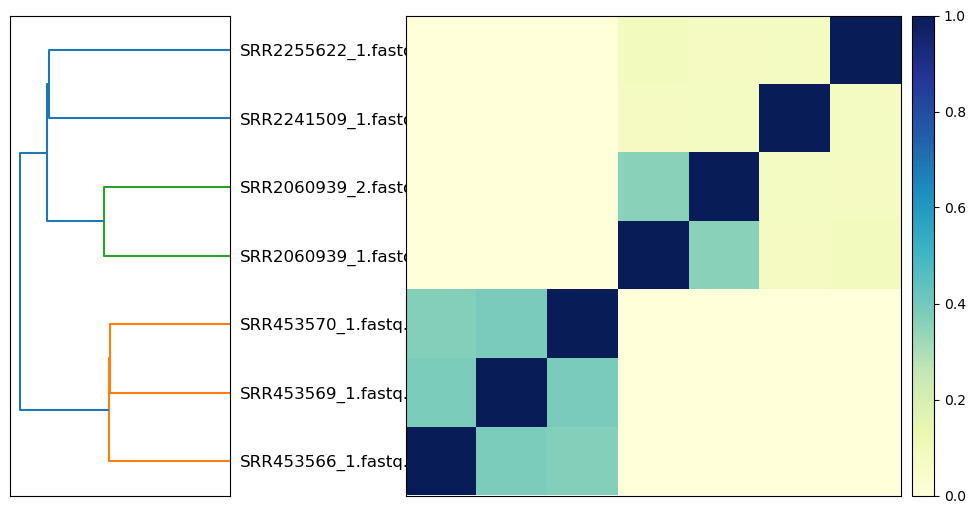

In [5]:
f, reordered_labels, reordered_matrix = fig.plot_composite_matrix(matrix, labels)

In [6]:
print('reordered matrix:\n', reordered_matrix)
print('reordered labels:', reordered_labels)

reordered matrix:
 [[1.    0.382 0.364 0.    0.    0.    0.   ]
 [0.382 1.    0.386 0.    0.    0.    0.   ]
 [0.364 0.386 1.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.356 0.078 0.086]
 [0.    0.    0.    0.356 1.    0.072 0.078]
 [0.    0.    0.    0.078 0.072 1.    0.074]
 [0.    0.    0.    0.086 0.078 0.074 1.   ]]
reordered labels: ['SRR453566_1.fastq.gz', 'SRR453569_1.fastq.gz', 'SRR453570_1.fastq.gz', 'SRR2060939_1.fastq.gz', 'SRR2060939_2.fastq.gz', 'SRR2241509_1.fastq.gz', 'SRR2255622_1.fastq.gz']


## Customizing plots

If you want to customize the plots, please see the code for `plot_composite_matrix` in [sourmash/fig.py](https://github.com/sourmash-bio/sourmash/blob/latest/src/sourmash/fig.py), which is reproduced below; you can modify the code in place to (for example) [use custom dendrogram colors](https://stackoverflow.com/questions/38153829/custom-cluster-colors-of-scipy-dendrogram-in-python-link-color-func).

In [7]:
import scipy.cluster.hierarchy as sch

def plot_composite_matrix(D, labeltext, show_labels=True, show_indices=True,
                          vmax=1.0, vmin=0.0, force=False):
    """Build a composite plot showing dendrogram + distance matrix/heatmap.
    Returns a matplotlib figure."""
    if D.max() > 1.0 or D.min() < 0.0:
        error('This matrix doesn\'t look like a distance matrix - min value {}, max value {}', D.min(), D.max())
        if not force:
            raise ValueError("not a distance matrix")
        else:
            notify('force is set; scaling to [0, 1]')
            D -= D.min()
            D /= D.max()

    if show_labels:
        show_indices = True

    fig = pylab.figure(figsize=(11, 8))
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])

    # plot dendrogram
    Y = sch.linkage(D, method='single')  # centroid

    dendrolabels = labeltext
    if not show_labels:
        dendrolabels = [str(i) for i in range(len(labeltext))]

    Z1 = sch.dendrogram(Y, orientation='left', labels=dendrolabels,
                        no_labels=not show_indices)
    ax1.set_xticks([])

    xstart = 0.45
    width = 0.45
    if not show_labels:
        xstart = 0.315
    scale_xstart = xstart + width + 0.01

    # plot matrix
    axmatrix = fig.add_axes([xstart, 0.1, width, 0.6])

    # (this reorders D by the clustering in Z1)
    idx1 = Z1['leaves']
    D = D[idx1, :]
    D = D[:, idx1]

    # show matrix
    im = axmatrix.matshow(D, aspect='auto', origin='lower',
                          cmap=pylab.cm.YlGnBu, vmin=vmin, vmax=vmax)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([scale_xstart, 0.1, 0.02, 0.6])
    pylab.colorbar(im, cax=axcolor)

    return fig

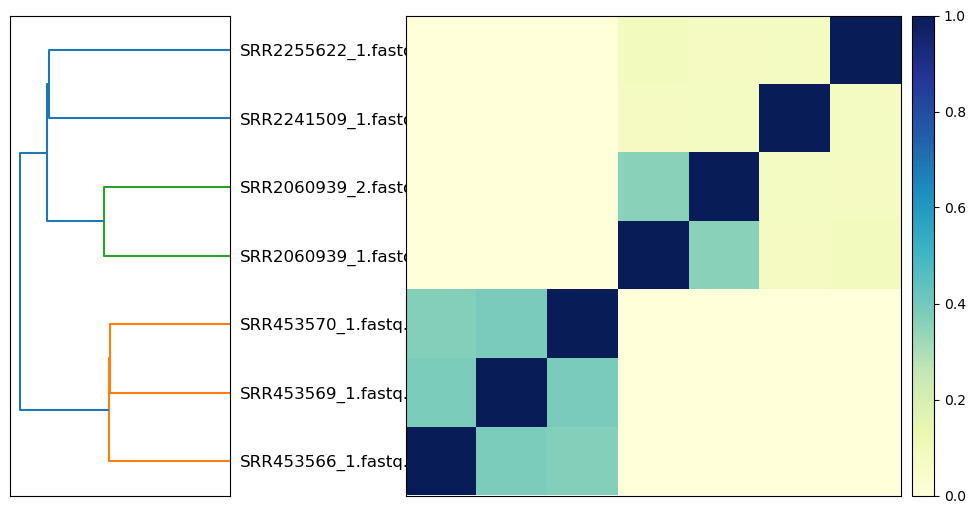

In [8]:
_ = plot_composite_matrix(matrix, labels)